# 서울시 지하철 유동인구 예측 (개선된 LSTM 모델 적용)
- 시계열 입력 길이 증가 (seq_length=7)
- LSTM 노드 수 증가 및 구조 개선
- 학습 epoch 증가
- 예측 결과 및 RMSE 확인

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 데이터 로딩 및 집계
df = pd.read_csv('CARD_SUBWAY_MONTH_202503.csv', encoding='utf-8-sig')
df['사용일자'] = pd.to_datetime(df['사용일자'], format='%Y%m%d')
df_grouped = df.groupby('사용일자')[['승차총승객수', '하차총승객수']].sum().reset_index()
df_grouped['total'] = df_grouped['승차총승객수'] + df_grouped['하차총승객수']

In [13]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_grouped[['total']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(scaled, seq_length)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [15]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0)

C:\Users\gunho\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# 예측 및 RMSE
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'LSTM 예측 RMSE: {rmse:,.2f}명')
print('\n예측값 샘플:', np.round(y_pred_inv[:5].flatten(), 2))
print('실제값 샘플:', np.round(y_test_inv[:5].flatten(), 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
LSTM 예측 RMSE: 1,560,734.21명

예측값 샘플: [16595201. 15445295. 12460045. 11847909. 14662802.]
실제값 샘플: [16330350. 17060905. 12617151.  8945629. 15688084.]


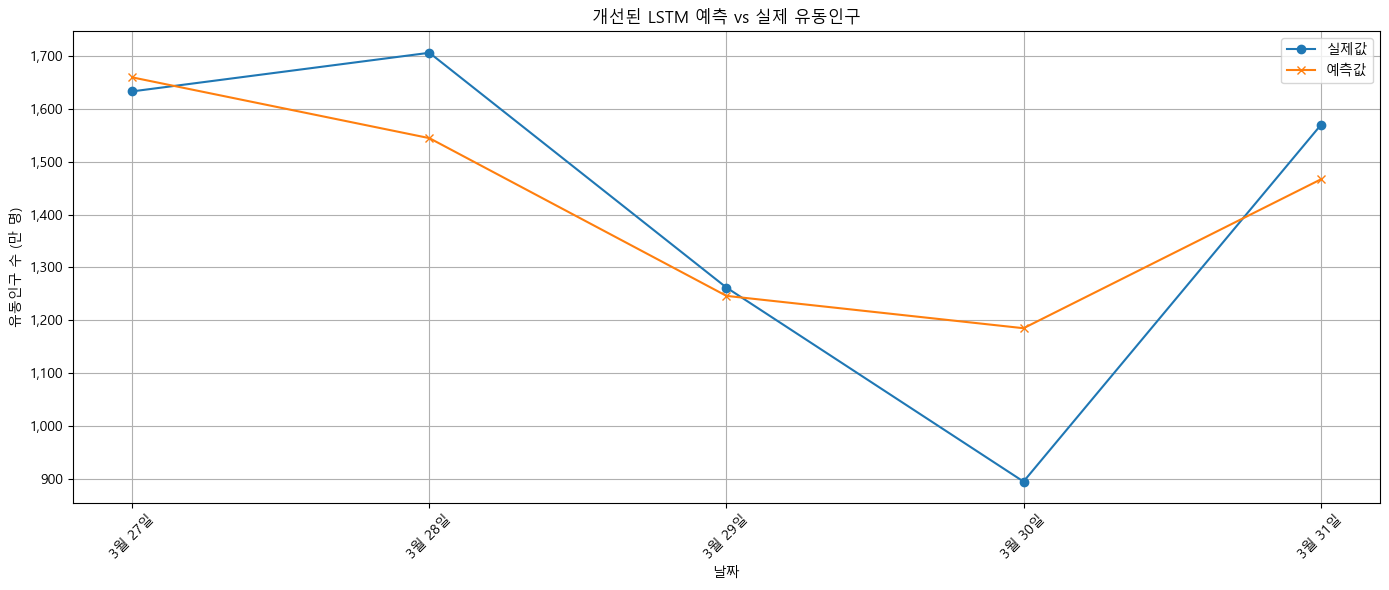

In [23]:
# ✅ X축 날짜 준비
start_index = len(df_grouped) - len(y_test_inv)  # 예측 시작 시점 인덱스
x_dates = df_grouped['사용일자'].iloc[start_index:].dt.strftime("3월 %d일")

# ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(x_dates, y_test_inv, label='실제값', marker='o')
plt.plot(x_dates, y_pred_inv, label='예측값', marker='x')
plt.title('개선된 LSTM 예측 vs 실제 유동인구')
plt.xlabel('날짜')
plt.ylabel('유동인구 수 (만 명)')
plt.xticks(rotation=45)

# ✅ Y축 단위를 "만 명"으로 표시
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-4:,.0f}'))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()